In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cPickle as pickle
import feature_calculations as fc
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from resizeimage import resizeimage
#from PIL import Image
#import commands
#import os

# Load the inception model

In [16]:
def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile('../data/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

# Load or compute pool3 for frames

In [17]:
my_dict = {}
if os.path.exists('../data/camelyon_pool3.pkl'):
    my_dict = pickle.load(open('../data/camelyon_pool3.pkl', 'rb'))
else:
    # create inceptions graph
    create_graph()
    sess = tf.InteractiveSession()
    pool3_tensor = sess.graph.get_tensor_by_name('pool_3:0')
    for i in ['../data/slide_data/camelyon_metastatic/', '../data/slide_data/camelyon_normal/']:
        # check that folder exists
        if not os.path.isdir(i): print "WARNING::Directory '", i, "' does not exist! Skipping..."; continue
        # get list of files
        files = os.listdir(i)
        for j,iFile in enumerate(files):
            if (j%100==0): print "working on file #", j
            if not '.jpeg' in iFile: continue # skip file that are not images
            file_path = os.path.join(i,iFile) # full file path
            img = cv2.imread(file_path) # load image for cv2
            if float(fc.compute_white_area_1(img)) > 0.95: continue # same cleaning applied on 6 feature classifier
            thisFrame = {} #dictionary for this frame
            thisFrame['label'] = ('metastatic' in i)*'metastatic' + ('normal' in i)*'normal' #label
            img_data = tf.gfile.FastGFile(file_path, 'rb').read() # load for tensorflow
            thisFrame['pool3'] = np.squeeze(sess.run(pool3_tensor, {'DecodeJpeg/contents:0':img_data})) #features
            file_ID = iFile.split('.')[1] #frame ID
            my_dict[file_ID] = thisFrame
    pickle.dump( my_dict, open( "../data/camelyon_pool3.pkl", "wb" ) )

# Use same test/train split as 6 feature classifier

In [32]:
setIDs = pickle.load(open('../data/train_cv_test_fileIDs.pkl', 'rb'))
trainIDs = setIDs['train']
cvIDs = setIDs['cv']
testIDs = setIDs['test']

In [33]:
trainX = [my_dict[x[0]]['pool3'] for x in trainIDs]
trainY = [my_dict[x[0]]['label']=='metastatic' for x in trainIDs]
cvX = [my_dict[x[0]]['pool3'] for x in cvIDs]
cvY = [my_dict[x[0]]['label']=='metastatic' for x in cvIDs]
testX = [my_dict[x[0]]['pool3'] for x in testIDs]
testY = [my_dict[x[0]]['label'] for x in testIDs]

# Let's look at the training set 
## Try first six PCA features (e.g. get a comparison to my engineered 6 features)

In [55]:
scaler = preprocessing.StandardScaler().fit(trainX)

In [78]:
pca = PCA(n_components=6)
pca = pca.fit(scaler.transform(trainX))
sum(pca.explained_variance_ratio_)

0.34619494080093616

In [79]:
pca6_trainX = pca.transform(scaler.transform(trainX))

In [80]:
def plot_pca_component(component, dataX, dataY, nBins, title, xlabel, ylabel):
    comp_index = component - 1
    histogram = plt.figure()
    bins = np.linspace(np.min(dataX), np.max(dataX), nBins)
    plt.hist([dataX[x][comp_index] for x in range(len(dataX)) if not dataY[x]], bins, weights=np.ones(len(dataY)-sum(dataY))/(len(dataY)-sum(dataY)), alpha=0.5, label='normal')
    plt.hist([dataX[x][comp_index] for x in range(len(dataX)) if dataY[x]], bins, weights=np.ones(sum(dataY))/(sum(dataY)), alpha=0.5, label='metastatic')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    return histogram

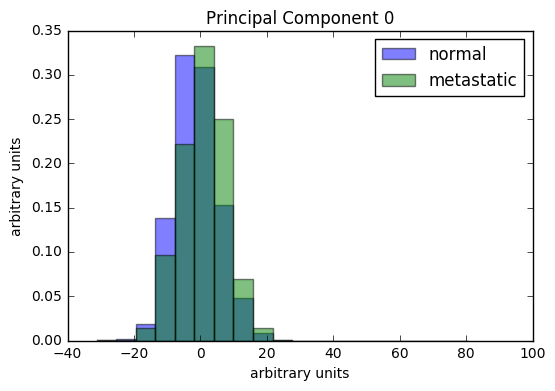

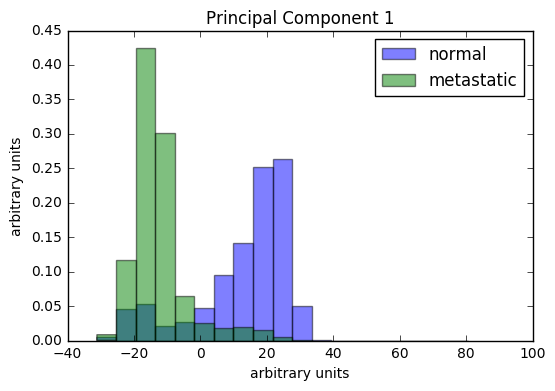

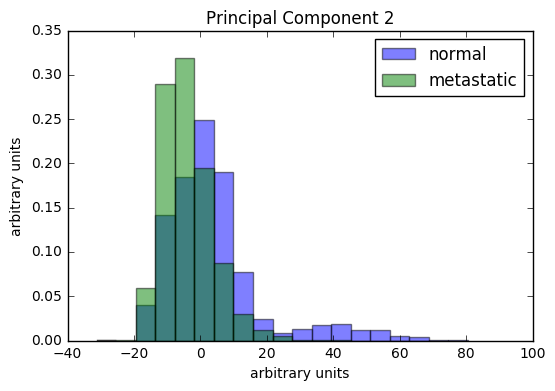

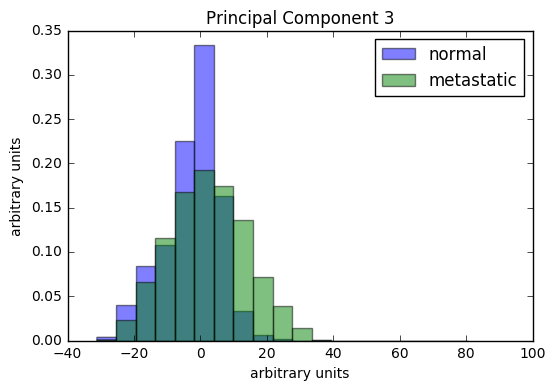

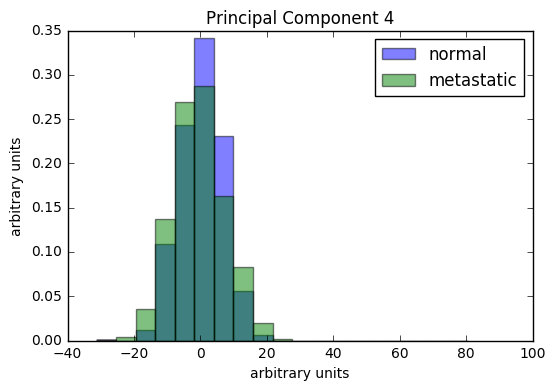

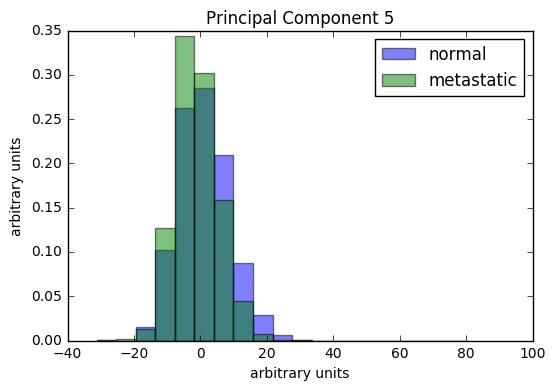

In [81]:
for i in range(6):
    plot_pca_component(i, pca.transform(scaler.transform(trainX)), trainY, 20, 'Principal Component '+str(i), 'arbitrary units', 'arbitrary units')

# Let's try logistic regression as a function of the number of PCs
## ...and compare regularization parameters!

In [95]:
nPCAScoreDict = {}
for i in range(1,500,10):
    if (i-1)%100 == 0: print "iteration", i
    pca = PCA(n_components=i)
    pca.fit(scaler.transform(trainX))
    model = LogisticRegression(C=0.01).fit(pca.transform(scaler.transform(trainX)), trainY)
    nPCAScoreDict[i] = model.score(pca.transform(scaler.transform(cvX)), cvY)

iteration 1
iteration 101
iteration 201
iteration 301
iteration 401


In [96]:
nPCAScoreDictNoReg = {}
for i in range(1,500,10):
    if (i-1)%100 == 0: print "iteration", i
    pca = PCA(n_components=i)
    pca.fit(scaler.transform(trainX))
    model = LogisticRegression(C=30).fit(pca.transform(scaler.transform(trainX)), trainY)
    nPCAScoreDictNoReg[i] = model.score(pca.transform(scaler.transform(cvX)), cvY)

iteration 1
iteration 101
iteration 201
iteration 301
iteration 401


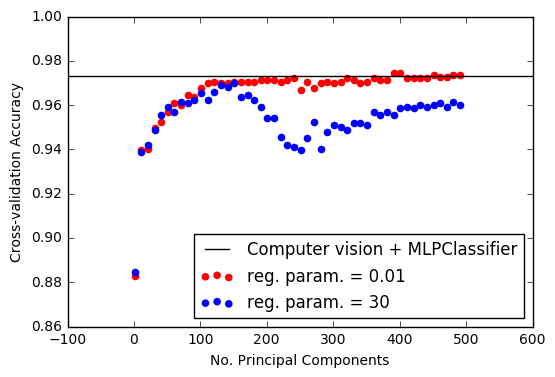

In [100]:
plt.scatter(nPCAScoreDict.keys(), nPCAScoreDict.values(), color='red', label='reg. param. = 0.01')
plt.scatter(nPCAScoreDictNoReg.keys(), nPCAScoreDictNoReg.values(), color='blue', label='reg. param. = 30')
plt.axhline(0.973, label = 'Computer vision + MLPClassifier', color='black')
plt.xlabel('No. Principal Components')
plt.ylabel('Cross-validation Accuracy')
plt.legend(loc=4)

# Learning curve!

In [105]:
nTrainScoreDict = {}
for i in range(2, len(trainX), 20):
    if (i-2)%1000 == 0: print "i=",i
    nPCA = min(i,200)
    thisTrainX = trainX[:i]
    thisTrainY = trainY[:i]
    thisScaler = preprocessing.StandardScaler().fit(thisTrainX)
    thisPCA = PCA(n_components=nPCA).fit(thisScaler.transform(thisTrainX))
    model = LogisticRegression(C=0.01).fit(thisPCA.transform(thisScaler.transform(thisTrainX)),thisTrainY)
    nTrainScoreDict[i] = model.score(thisPCA.transform(thisScaler.transform(cvX)), cvY)

i= 2
i= 1002
i= 2002
i= 3002


In [107]:
nTrainScoreDictNoReg = {}
for i in range(2, len(trainX), 20):
    if (i-2)%1000 == 0: print "i=",i
    nPCA = min(i,200)
    thisTrainX = trainX[:i]
    thisTrainY = trainY[:i]
    thisScaler = preprocessing.StandardScaler().fit(thisTrainX)
    thisPCA = PCA(n_components=nPCA).fit(thisScaler.transform(thisTrainX))
    model = LogisticRegression(C=30).fit(thisPCA.transform(thisScaler.transform(thisTrainX)),thisTrainY)
    nTrainScoreDictNoReg[i] = model.score(thisPCA.transform(thisScaler.transform(cvX)), cvY)

i= 2
i= 1002
i= 2002
i= 3002


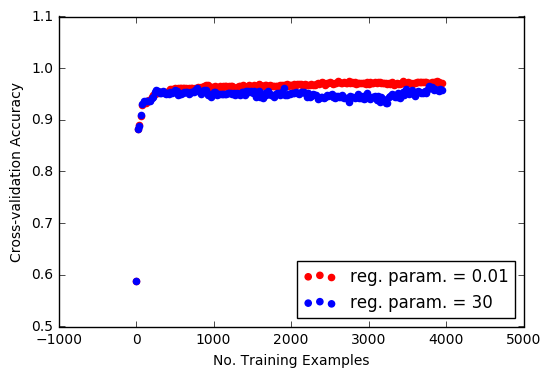

In [108]:
plt.scatter(nTrainScoreDict.keys(), nTrainScoreDict.values(), color='red', label='reg. param. = 0.01')
plt.scatter(nTrainScoreDictNoReg.keys(), nTrainScoreDictNoReg.values(), color='blue', label='reg. param. = 30')
#plt.axhline(0.973, label = 'Computer vision + MLPClassifier', color='black')
plt.xlabel('No. Training Examples')
plt.ylabel('Cross-validation Accuracy')
plt.legend(loc=4)